In [133]:

import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed

import discretize
# from simpeg import dask
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    Data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation, MetaSimulation


Solver = get_default_solver()


directory = "../synthetic-data-10m"
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.split(".")[-1]=="txt"]

files.remove("rx_locs.txt")
# rx_locs = np.loadtxt(f"{directory}/rx_locs.txt")
# rx_locs[:, 1] =
tx_height = 30 

rx_x = (np.linspace(-700, 700, 141))[::4]

rx_y = np.r_[-200, -100, 0, 100, 200]
rx_z = tx_height

rx_locs = discretize.utils.ndgrid([rx_x, rx_y, rx_z])
rx_x

files.remove("rx_times.txt")
rx_times = np.loadtxt(f"{directory}/rx_times.txt")


In [134]:
1400/10

140.0

In [136]:
len(rx_x)

36

In [137]:
len(rx_locs[:, 0])

180

In [138]:
rx_times

array([0.0001    , 0.00011836, 0.00014008, 0.0001658 , 0.00019624,
       0.00023226, 0.0002749 , 0.00032536, 0.00038509, 0.00045579,
       0.00053946, 0.00063849, 0.0007557 , 0.00089443, 0.00105862,
       0.00125296, 0.00148297, 0.00175521, 0.00207742, 0.00245878,
       0.00291015, 0.00344438, 0.00407668, 0.00482506, 0.00571082,
       0.00675918, 0.008     ])

In [139]:
# dobs_dict = {}

# for f in files:
#     key = f.split(".")[0]
#     dobs_dict[key] = np.loadtxt(f"{directory}/{f}")
    
# data_dict = {}
n_times_invert = 20
# for key, value in dobs_dict.items():
source_list = []
for i in range(rx_locs.shape[0]):
    rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times[:n_times_invert], orientation="z")
    src = tdem.sources.CircularLoop(
        receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10,
        waveform=tdem.sources.StepOffWaveform()
    )
    source_list.append(src)

full_survey = tdem.Survey(source_list)

    # data_dict[key] = Data(survey=full_survey, dobs=value)



In [140]:
# n_times_invert = 20
# data_dict_invert = {}
    
# for key, value in dobs_dict.items():

#     source_list = []

#     for i in range(rx_locs.shape[0]):
#         rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times[:n_times_invert], orientation="z")
#         src = tdem.sources.CircularLoop(
#             receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10,
#             waveform=tdem.sources.StepOffWaveform()
#         )
#         source_list.append(src)

#     survey = tdem.Survey(source_list)

#     data_dict_invert[key] = Data(
#         survey=survey,
#         dobs=(value.reshape(rx_locs.shape[0], len(rx_times))[:, :n_times_invert]).flatten(),
#         relative_error=0.1,
#         noise_floor=1e-11
#     )

In [141]:
survey = full_survey

In [142]:
downsample = 1
source_list_downsampled = survey.source_list[::downsample]

with open("survey.txt", "w") as f:
    f.write(f"N_TRX {len(source_list_downsampled)}\n\n")

    for src in source_list_downsampled: 
        f.write(f"TRX_LOOP\n")
        f.write(f"{src.location[0]} {src.location[1]} {src.location[2]} {src.radius} 0 0\n\n")

        f.write(f"N_RECV 1\n")
        f.write(f"N_TIME {n_times_invert}\n")
        for t in rx_times[:n_times_invert]:
            rx = src.receiver_list[0]
            f.write(f"{rx.locations[0, 0]} {rx.locations[0, 1]} {rx.locations[0, 2]} {t}\n")
        f.write("\n")
            


        

In [143]:
src = survey.source_list[0]
rx = src.receiver_list[0]

In [145]:
ubc_mesh = discretize.TreeMesh.read_UBC("octree_mesh.txt")

In [146]:
def dipping_target_indices(
    mesh, target_x_center, target_z_center, dip, target_thickness, target_xlim=None, target_ylim=None, target_zlim=None
): 
    """
    add a dipping target to the model. For now assumes the target dips in the x-direction
    """
    x_center = np.mean(target_x)
    slope = np.tan(-dip*np.pi/180)
    target_z = target_z_center + target_thickness / 2 * np.r_[-1, 1]
    
    z_bottom = (mesh.cell_centers[:, 0] - target_x_center) * slope + target_z.min()
    z_top = (mesh.cell_centers[:, 0] - target_x_center) * slope + target_z.max()

    indices = (
        (mesh.cell_centers[:, 2] >= z_bottom) &
        (mesh.cell_centers[:, 2] <= z_top) 
    )

    if target_xlim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 0] >= target_xlim.min()) &
            (mesh.cell_centers[:, 0] <= target_xlim.max())
        )
    if target_ylim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 1] >= target_ylim.min()) &
            (mesh.cell_centers[:, 1] <= target_ylim.max())
        )
    if target_zlim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 2] >= target_zlim.min()) &
            (mesh.cell_centers[:, 2] <= target_zlim.max())
        )
    return indices

In [147]:
rho_back = 500
sigma_back = 1./rho_back 

rho_target = 20
sigma_target = 1./rho_target

sigma_air = 1e-8

target_dips = np.r_[0, 15, 30, 45]
target_z = np.r_[-200, -20]

In [148]:
models = {}

target_x = np.r_[-400, 400]
target_y = np.r_[-40, 40]
target_z_center = -60
target_thickness = 40

# background model
background = np.ones(ubc_mesh.n_cells) * sigma_air
background[ubc_mesh.cell_centers[:, 2] < 0] = sigma_back
models["background"] = background

for dip in target_dips:
    model = background.copy()
    indices = dipping_target_indices(
        ubc_mesh, target_x_center=-100, target_z_center=target_z_center, 
        target_thickness=target_thickness, dip=dip, 
        target_xlim=target_x, 
        target_ylim=target_y,
        target_zlim=target_z
    )
    model[indices] = sigma_target
    models[f"target_{dip}"] = model



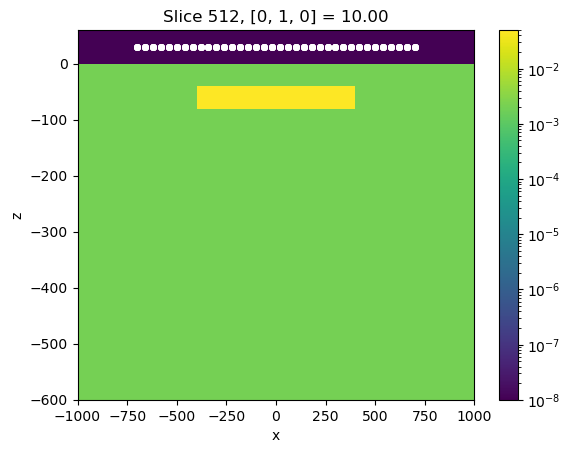

In [149]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(
    ubc_mesh.plot_slice(
        models["target_0"], ax=ax, pcolor_opts={"norm":LogNorm()}, 
        normal="Y",
    )[0], ax=ax
)

ax.set_xlim(1000*np.r_[-1, 1])
ax.set_ylim(np.r_[-600, 60])
ax.plot(rx_locs[:, 0], rx_locs[:, 2], "wo", ms=4)

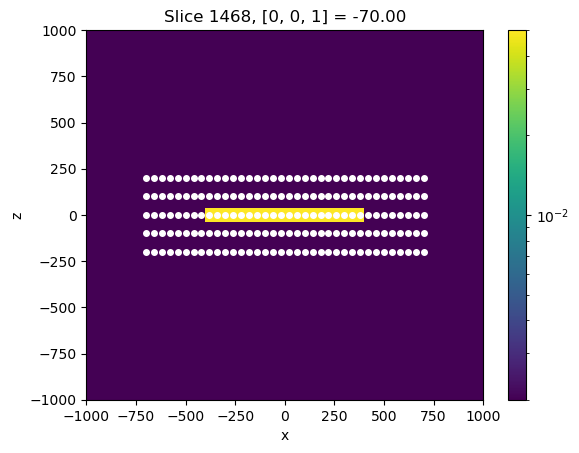

In [150]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(
    ubc_mesh.plot_slice(
        models["target_0"], ax=ax, pcolor_opts={"norm":LogNorm()}, 
        normal="Z", ind=1468
    )[0], 
    ax=ax
)

ax.set_xlim(1000*np.r_[-1, 1])
ax.set_ylim(1000*np.r_[-1, 1])

ax.plot(rx_locs[:, 0], rx_locs[:, 1], "wo", ms=4)

In [151]:
discretize.TreeMesh.write_model_UBC(ubc_mesh, "target_0.con", models["target_0"])

In [109]:
relative_error = 0.05
noise_floor = 1e-13

In [152]:
def load_pre_file(filepath):
    """
    Load a GIF-style .pre file (TDoctree format).

    Parameters
    ----------
    filepath : str
        Path to the .pre-style data file

    Returns
    -------
    dict
        {
            "ignore": float or None,
            "n_trx": int,
            "transmitters": list of {
                "location": list of float,
                "n_recv": int,
                "n_time": int,
                "receivers": list of {
                    "loc": (x, y, z),
                    "time": float,
                    "data": list of float
                }
            }
        }
    """
    with open(filepath, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    i = 0
    ignore_value = None
    transmitters = []

    # Parse IGNORE line if present
    if lines[i].startswith("IGNORE"):
        ignore_value = float(lines[i].split()[1])
        i += 1

    # Parse number of transmitters
    if lines[i].startswith("N_TRX"):
        n_trx = int(lines[i].split()[1])
        i += 1
    else:
        raise ValueError("Missing N_TRX line")

    while i < len(lines):
        if lines[i].startswith("TRX_LOOP"):
            i += 1
            location = list(map(float, lines[i].split()))
            i += 1
            if not lines[i].startswith("N_RECV"):
                raise ValueError("Expected N_RECV")
            n_recv = int(lines[i].split()[1])
            i += 1
            if not lines[i].startswith("N_TIME"):
                raise ValueError("Expected N_TIME")
            n_time = int(lines[i].split()[1])
            i += 1

            receivers = []
            for _ in range(n_recv * n_time):
                parts = lines[i].split()
                x, y, z = map(float, parts[0:3])
                time = float(parts[3])
                data = list(map(float, parts[4:]))
                receivers.append({
                    "loc": (x, y, z),
                    "time": time,
                    "data": data
                })
                i += 1

            transmitters.append({
                "location": location,
                "n_recv": n_recv,
                "n_time": n_time,
                "receivers": receivers
            })
        else:
            i += 1  # Skip unknown or empty lines

    return {
        "ignore": ignore_value,
        "n_trx": len(transmitters),
        "transmitters": transmitters
    }


In [153]:
dobs = load_pre_file("dpred-fwd.txt")

In [154]:
dobs_values = np.zeros((n_times_invert, len(dobs["transmitters"])))

In [155]:
for i in range(len(dobs["transmitters"])): 
    for j in range(n_times_invert): 
        dobs_values[j, i] = dobs["transmitters"][i]["receivers"][j]["data"][-1]

In [156]:
dobs_values

array([[3.461763e-09, 3.484447e-09, 3.520014e-09, ..., 3.521413e-09,
        3.485482e-09, 3.462624e-09],
       [2.319641e-09, 2.338322e-09, 2.364794e-09, ..., 2.365594e-09,
        2.338930e-09, 2.320125e-09],
       [1.524137e-09, 1.538220e-09, 1.556317e-09, ..., 1.556428e-09,
        1.538263e-09, 1.524129e-09],
       ...,
       [3.492101e-12, 3.486688e-12, 3.492124e-12, ..., 3.487334e-12,
        3.481943e-12, 3.487343e-12],
       [2.312977e-12, 2.309892e-12, 2.312744e-12, ..., 2.308737e-12,
        2.305904e-12, 2.308956e-12],
       [1.523608e-12, 1.521914e-12, 1.523395e-12, ..., 1.520299e-12,
        1.518828e-12, 1.520498e-12]])

In [157]:
data_invert = Data(survey, dobs = discretize.utils.mkvc(dobs_values))


In [158]:
len(rx_x)

36

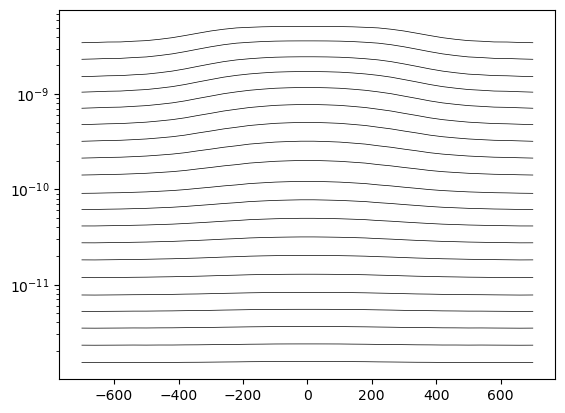

In [166]:
fig, ax = plt.subplots(1, 1)

line_number = 4

ax.semilogy(rx_x, data_invert.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :], color="k", lw=0.5);
# ax.semilogy(rx_locs[::3, 0], dpred_values.T, "C0o", ms=2);

In [167]:

source_list = data_invert.survey.source_list

with open("dobs.txt", "w") as f:
    f.write(f"IGNORE -9.9999000e+004\n")
    f.write(f"N_TRX {len(source_list)}\n\n")

    for src in source_list: 
        f.write(f"TRX_LOOP\n")
        f.write(f"{src.location[0]}\t{src.location[1]}\t{src.location[2]}\t{src.radius}\t0\t0\n\n")

        f.write(f"N_RECV 1\n")
        f.write(f"N_TIME {n_times_invert}\n")
        for i, t in enumerate(rx_times[:n_times_invert]):
            rx = src.receiver_list[0]
            datum = data_invert[src, rx][i]
            std = np.abs(datum) * relative_error + noise_floor
            f.write(
                f"{rx.locations[0, 0]}\t{rx.locations[0, 1]}\t{rx.locations[0, 2]}\t{t} "+
                f"-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t" + # E data 
                f"-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t" + # H data 
                f"-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t{datum}\t{std}\n"
            )
            
        f.write("\n")
            


        

In [168]:
time_steps = [
    (1e-6, 30),
    (3e-6, 30),
    (1e-5, 30), (3e-5, 20), (1e-4, 20), #(3e-4, 20)
]

In [169]:
full_time_mesh = np.cumsum(np.hstack([0, discretize.utils.unpack_widths(time_steps)]))
with open("waveform.txt", "w") as f:
    for i, t in enumerate(full_time_mesh): 
        if i == 0:
            f.write(f"{t} \t 1\n")
        else:
            f.write(f"{t} \t 0\n")

In [105]:
# fname = "dpred0.txt"
# with open(fname, 'r') as f:
#     lines = f.readlines()



In [108]:
len(dpred["transmitters"])

34

In [193]:
ubc_model = discretize.TreeMesh.read_model_UBC(ubc_mesh, "inv_004.con")

In [194]:
# with open(f"{directory}/true-models.pkl", "rb") as f:
#     true_models = pickle.load(f)

# simpeg_mesh = discretize.load_mesh(f"{directory}/treemesh.json")

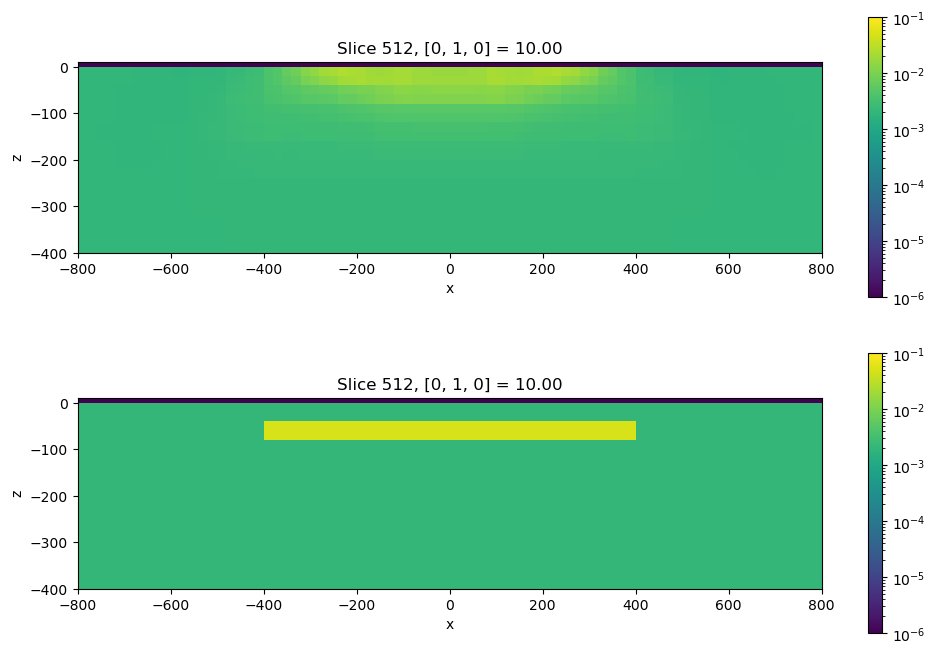

In [195]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8)) 

plt.colorbar(ubc_mesh.plot_slice(
    ubc_model, 
    pcolor_opts={"norm":LogNorm(vmin=1e-6, vmax=1e-1)},
    ax=ax[0],
    normal="Y",
    # grid=True,
)[0], ax=ax[0])

plt.colorbar(ubc_mesh.plot_slice(
    models["target_0"], 
    pcolor_opts={"norm":LogNorm(vmin=1e-6, vmax=1e-1)},
    ax=ax[1],
    normal="Y"
)[0], ax=ax[1])


for a in ax: 
    a.set_xlim(800* np.r_[-1, 1])
    a.set_ylim(-400, 10)
    a.set_aspect(1)

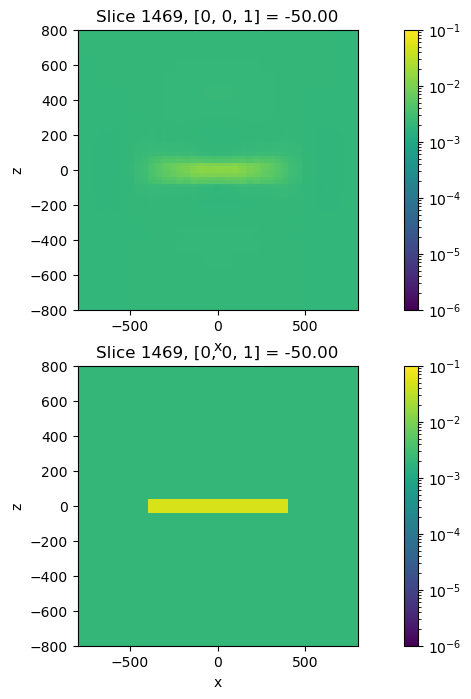

In [196]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8)) 
ind = 1469
plt.colorbar(ubc_mesh.plot_slice(
    ubc_model, 
    pcolor_opts={"norm":LogNorm(vmin=1e-6, vmax=1e-1)},
    ax=ax[0],
    normal="Z",
    ind=ind,
    # grid=True,
)[0], ax=ax[0])

plt.colorbar(ubc_mesh.plot_slice(
    models["target_0"], 
    pcolor_opts={"norm":LogNorm(vmin=1e-6, vmax=1e-1)},
    ax=ax[1],
    normal="Z",
    ind=ind,
)[0], ax=ax[1])


for a in ax: 
    a.set_xlim(800* np.r_[-1, 1])
    a.set_ylim(800* np.r_[-1, 1])
    a.set_aspect(1)

In [197]:
small_mesh = discretize.TreeMesh.read_UBC("octree_mesh_0050.txt")

(<matplotlib.collections.PolyCollection at 0x7f814135bb90>,)

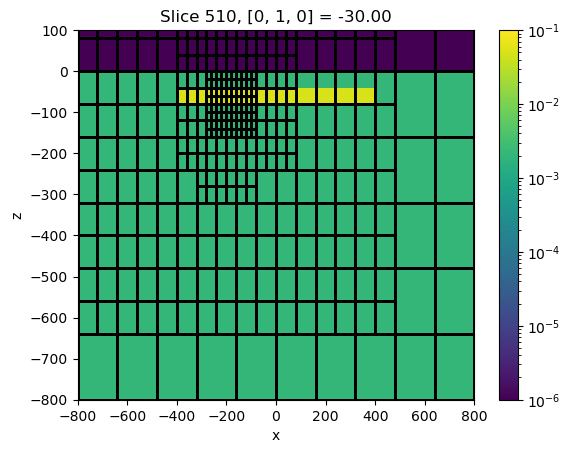

In [208]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(ubc_mesh.plot_slice(
    models["target_0"], 
    pcolor_opts={"norm":LogNorm(vmin=1e-6, vmax=1e-1)},
    ax=ax,
    normal="Y"
)[0], ax=ax)

ax.set_xlim(np.r_[-1, 1]*800)
ax.set_ylim(np.r_[-800, 100])

small_mesh.plot_slice(
    np.ones(small_mesh.n_cells)*np.inf, 
    ax=ax, 
    normal="Y",
    ind=510,
    grid=True
)

(-800.0, 800.0)

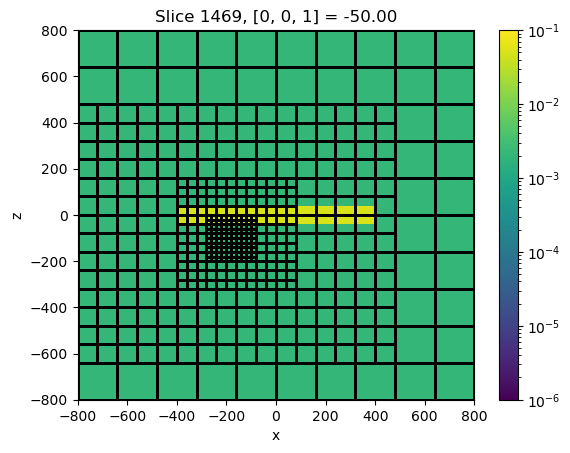

In [204]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(ubc_mesh.plot_slice(
    models["target_0"], 
    pcolor_opts={"norm":LogNorm(vmin=1e-6, vmax=1e-1)},
    ax=ax,
    normal="Z",
    ind=ind,
)[0], ax=ax)

small_mesh.plot_slice(
    np.ones(small_mesh.n_cells)*np.inf, 
    ax=ax, 
    normal="Z",
    grid=True,
    ind=ind
)
ax.set_xlim(np.r_[-1, 1]*800)
ax.set_ylim(np.r_[-1, 1]*800)